### utils

In [1]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np

In [2]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

In [3]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

### model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

### Train

In [9]:
import os
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np

import time
start_time = time.time()
torch.cuda.set_device(1)

In [10]:
# if not os.path.exists('ckpt'):
#     os.makedirs('output/animation')

In [11]:
# parameters
#TODO : set up all the parameters
epochs = 100    # number of epochs of training
batchsize = 40    # size of the batches
animation_root = './data1/'    # root directory of the dataset
cartoon_root = './data2/'    # root directory of the dataset
lr = 0.0003    # initial learning rate
size = 32   # size of the data crop (squared assumed)
input_nc = 3    # number of channels of input data
output_nc = 3    # number of channels of output data

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)
###################################
G_loss  = []
DA_loss  = []
DB_loss  = []

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


In [12]:
###### Training ######
for epoch in range(1, epochs):
    i=1
    print('epoch',epoch)
    for batch in zip(animation_loader, cartoon_loader):
        # Set model input
        A = torch.FloatTensor(batch[0][0])
        B = torch.FloatTensor(batch[1][0])
        real_A = Variable(input_A.copy_(A)).cuda()
        real_B = Variable(input_B.copy_(B)).cuda()

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        # TODO : calculate the loss for the generators, and assign to loss_G
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0
        
         # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # TODO : calculate the loss for a discriminator, and assign to loss_D_A
        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # TODO : calculate the loss for the other discriminator, and assign to loss_D_B
        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        
        loss_D_B.backward()
        
        optimizer_D_B.step()
        ###################################
        
        G_loss.append(loss_G.item())
        DA_loss.append(loss_D_A.item())
        DB_loss.append(loss_D_B.item())
        # Progress report
        if (i%10==0):
            print("loss_G : ",loss_G.data.cpu().numpy() ,",loss_D:", (loss_D_A.data.cpu().numpy() + loss_D_B.data.cpu().numpy()))
            i=0
        i=i+1
    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'ckpt/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'ckpt/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'ckpt/netD_A.pth')
    torch.save(netD_B.state_dict(), 'ckpt/netD_B.pth')
    
end_time = time.time()
print('Total cost time',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

epoch 1


/home/kuo/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_G :  13.976308 ,loss_D: 0.52753425
loss_G :  12.899631 ,loss_D: 0.20493141
loss_G :  10.15266 ,loss_D: 0.6345695
loss_G :  13.68185 ,loss_D: 0.81227624
loss_G :  9.358521 ,loss_D: 0.3008594
loss_G :  9.751273 ,loss_D: 0.09801486
loss_G :  8.317276 ,loss_D: 0.9209373
loss_G :  8.09373 ,loss_D: 1.2329246
loss_G :  7.7094707 ,loss_D: 0.55136925
loss_G :  9.990357 ,loss_D: 0.90303934
loss_G :  6.976062 ,loss_D: 0.71557224
loss_G :  8.170941 ,loss_D: 0.146195
loss_G :  7.7417254 ,loss_D: 0.4361455
loss_G :  6.7281356 ,loss_D: 1.3134906
loss_G :  7.067974 ,loss_D: 0.349698
loss_G :  6.827341 ,loss_D: 0.32642853
loss_G :  6.8442082 ,loss_D: 0.5562403
loss_G :  6.748109 ,loss_D: 0.8651715
loss_G :  6.973888 ,loss_D: 0.4520874
loss_G :  8.373672 ,loss_D: 0.4298428
loss_G :  6.757926 ,loss_D: 0.27293855
loss_G :  7.4028387 ,loss_D: 0.27896035
loss_G :  6.5016227 ,loss_D: 0.3925615
loss_G :  6.441473 ,loss_D: 0.26251012
loss_G :  6.0626254 ,loss_D: 0.6899877
epoch 2
loss_G :  6.4961047 ,loss

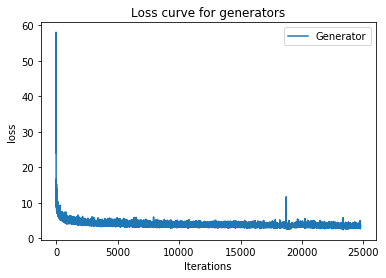

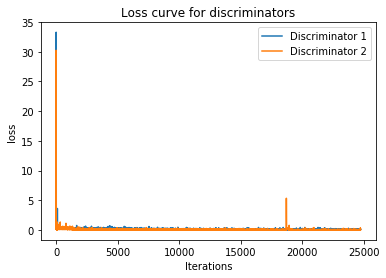

In [15]:
# TODO : plot the figure
import matplotlib.pyplot as plt
plt.plot(G_loss, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.title('Loss curve for generators')
plt.legend()
plt.savefig('2_G')
plt.show()

plt.plot(DA_loss, label='Discriminator 1')
plt.plot(DB_loss, label='Discriminator 2')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.title('Loss curve for discriminators')
plt.legend()
plt.savefig('2_D')
plt.show()

### Test

In [16]:
from torchvision.utils import save_image
import os
import sys

import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np

In [21]:
###### Definition of variables ######
# TODO : assign input_nc and output_nc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_nc = 3 # number of channels of input data
output_nc = 3 # number of channels of output data
batchsize = 1    # size of the batches
animation_root = './data1/'    # root directory of the dataset
cartoon_root = './data2/'    # root directory of the dataset
size = 32

# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)

# Load state dicts
netG_A2B.load_state_dict(torch.load('ckpt/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('ckpt/netG_B2A.pth'))

netG_A2B.to(device)
netG_B2A.to(device)

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)

# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)


if not os.path.exists('output/animation'):
    os.makedirs('output/animation')
if not os.path.exists('output/cartoon'):
    os.makedirs('output/cartoon')

i=0
for batch in zip(animation_loader, cartoon_loader):
    # Set model input
    A = torch.FloatTensor(batch[0][0])
    B = torch.FloatTensor(batch[1][0])
    real_A = Variable(input_A.copy_(A)).cuda()
    real_B = Variable(input_B.copy_(B)).cuda()

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(real_A, 'output/animation/real%04d.png' % (i+1))
    save_image(real_B, 'output/cartoon/real%04d.png' % (i+1))
    save_image(fake_A, 'output/animation/fake%04d.png' % (i+1))
    save_image(fake_B, 'output/cartoon/fake%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d' % (i+1))
    i = i+1
    if (i==10):
        break

sys.stdout.write('\n')

Generated images 0010


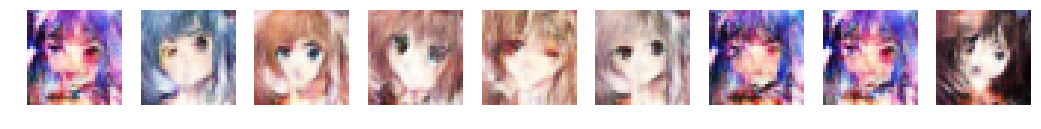

In [36]:
row = 1
column = 9

fig = plt.figure(figsize=(18, 2))
axes = fig.subplots(row, column)

fig_cnt = 1 

for j in range(column):
    axes[j].imshow(Image.open('./output/animation/fake000' + str(fig_cnt) + '.png'), interpolation='nearest')
    axes[j].set_axis_off()
    
    fig_cnt += 1

plt.savefig('2_animation_fake.jpg')
plt.show()
plt.close()

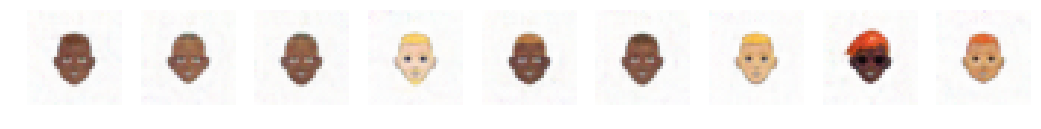

In [35]:
row = 1
column = 9

fig = plt.figure(figsize=(18, 2))
axes = fig.subplots(row, column)

fig_cnt = 1 

for j in range(column):
    axes[j].imshow(Image.open('./output/cartoon/fake000' + str(fig_cnt) + '.png'), interpolation='nearest')
    axes[j].set_axis_off()
    
    fig_cnt += 1

plt.savefig('2_cartoon_fake.jpg')
plt.show()
plt.close()